# RL Exercise Demo
This exercise serves as a demonstration how to quickly train an RL agent on a popular environment with a RL framework.
We will
1. Select and instantiate environment (gym's BipedalWalker-v3).
2. Select and setup our RL algorithm / agent (stablebaselines3 [SAC](https://spinningup.openai.com/en/latest/algorithms/sac.html)).
3. Train the agent on the environment and visualize training progress.
4. Evaluate our agent and observe the distribution of test performances.
5. Record and replay the agent, before and after.

## The Environment: Bipedal Walker
![Bipedal Walker](bipedal_walker.gif) [credits](https://www.gymlibrary.dev/_images/bipedal_walker.gif)

![Interaction Env-Agent](env_agent.png)

### Env
- locomotion
- 4 joints

### Action Space
- motor speed for all 4 joints (hips and knees) [-1, 1]

### Observation Space
State consists of
- hull angle speed
- angular velocity
- horizontal speed
- vertical speed
- position of joints
- joints angular speed
- legs contact with ground
- 10 lidar rangefinder measurements

There are no coordinates! State vector with 24 entries.

### Rewards
Moving forward gives rewards.
Falling is punished.
Applying motor torque costs a little.


### Starting State
Stands at the left in a certain position.

### Episode Termination
- walker falls
- or reaches end of terrain


In [1]:
import pandas as pd

model_fn = "trained_agent.zip"
env_id = "BipedalWalker-v3"
log_dir = "logs/tensorboard"

## The Agent: SAC
SAC: Soft Actor Critic
[[paper]](https://arxiv.org/abs/1801.01290) [[blogpost]](https://spinningup.openai.com/en/latest/algorithms/sac.html)

- off-policy algorithm
- for continuous actions
- one actor, one critic
- special regularization to steer exploration-exploitation trade-off 

In [ ]:
import gym
from stable_baselines3 import SAC

env = gym.make(env_id)
model = SAC("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
model.learn(total_timesteps=500_000)
model.save(model_fn)

# Rollout

## Evaluate Trained and Random Agent

In [29]:
import gym
import pandas as pd
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import SAC


n_eval_episodes = 10


# Create/ load agents

# Untrained agent
env = gym.make(env_id)
untrained_agent = SAC("MlpPolicy", env, verbose=0)

# Trained agents
trained_agent = SAC.load(model_fn)

agents = {
    "untrained": untrained_agent,
    "trained": trained_agent,
}

# Create env to evaluate
env = DummyVecEnv([lambda: gym.make(env_id)])
env = Monitor(gym.make(env_id))

# Evaluate each agent and gather results
results = []
for name, agent in agents.items():
    # Rollout n_eval_episodes and record performance
    means, stds = evaluate_policy(agent, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    performance = np.mean(means)
    results.append(pd.DataFrame({
        "agent": name,
        "episode": np.arange(0, n_eval_episodes),
        "reward": means,
        "length": stds,
    }))
results = pd.concat(results).reset_index(drop=True)

agent  episode      reward  length
0   untrained        0  -93.029525     103
1   untrained        1  -93.013591     103
2   untrained        2  -92.857543     109
3   untrained        3  -93.052581     104
4   untrained        4  -93.057285     104
5   untrained        5  -92.734779     101
6   untrained        6  -92.917871     104
7   untrained        7  -93.017067     104
8   untrained        8  -92.952616     105
9   untrained        9  -92.820710     103
10    trained        0  302.361579     925
11    trained        1  299.615659     962
12    trained        2  303.914557     904
13    trained        3  298.962662     963
14    trained        4  298.613614     958
15    trained        5  303.375655     902
16    trained        6  303.934267     908
17    trained        7  303.227167     915
18    trained        8  303.027576     895
19    trained        9  303.416011     903

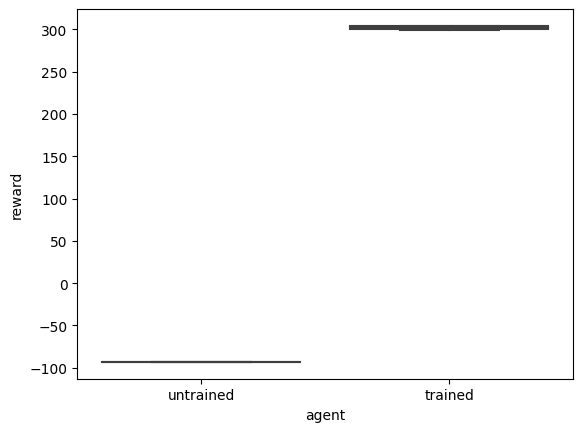

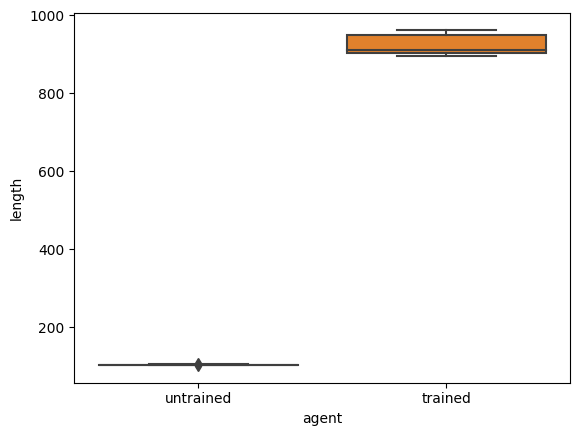

In [31]:
from rich import print as printr
import seaborn as sns
import matplotlib.pyplot as plt

df = results
printr(df)

ax = sns.boxplot(data=df, x="agent", y="reward")
plt.show()

sns.boxplot(data=df, x="agent", y="length")
plt.show()

In [2]:
video_folder = "logs/videos/"
video_length = 1000

## Record random agent

In [ ]:
import gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

# This creates a vectorized env (here of length 1). Is useful for parallelization
# when we have several workers that can perform individual rollouts.
env = DummyVecEnv([lambda: gym.make(env_id)])

env = VecVideoRecorder(
    env,
    video_folder,
    record_video_trigger=lambda x: x == 0,
    video_length=video_length,
    name_prefix=f"random-agent-{env_id}",
)

n_steps = video_length

# Reset and initialize the environment
obs = env.reset()

# For the number of frames
for i in range(n_steps):
    # Sample a random action from the action space
    action = [env.action_space.sample()]

    # Step the environment
    obs, reward, done, info = env.step(action)
    if done:
        # If the env signals the end of the episode, stop recording
        break
        obs = env.reset()
# Close / cleanup env
env.close()

## Record trained agent

In [ ]:
from stable_baselines3 import SAC
import gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env = DummyVecEnv([lambda: gym.make(env_id)])

# Record the video starting at the first step
env = VecVideoRecorder(
    env,
    video_folder,
    record_video_trigger=lambda x: x == 0,
    video_length=video_length,
    name_prefix=f"trained-agent-{env_id}",
)

model = SAC.load(model_fn)

n_steps = video_length

obs = env.reset()
for i in range(n_steps):
    # Now PREDICT the action to take with the trained model 🤖
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done:
        break
        obs = env.reset()
env.close()